# Does New Metric Solve the Early Year Instability Problem?

Early year models are unstable there isn't a whole lot of data to appropriately train word2vec model. [04_novel_distance_calculations](04_novel_distance_calculations.ipynb) notebook was designed to create a metric that can account for this problem.
This notebook is designed to test if the newly constructed metric actually fixes the problem via a global comparison using all tokens present in 2000 through 2020.

*Note*: compare the global qst metric to one of the earlier year models. The comparison should be similar to the one I did on a global scale.
Goal here is to show that this metric works better to handle the model instability that occurs.

In [1]:
from pathlib import Path
import re

import pandas as pd
import plotnine as p9
import plydata as ply
import plydata.tidy as ply_tdy
import tqdm

# Load distances for all Year Pairs

## load the years

In [2]:
subsetted_tokens = pd.read_csv("output/subsetted_tokens.tsv", sep="\t")
token_filter_list = subsetted_tokens.tok.tolist()
subsetted_tokens.head()

,tok
0,united
1,combining
2,purinergic
3,decomposition
4,60.0


In [3]:
distance_files = list(
    Path("output/combined_inter_intra_distances").rglob("saved_*_distance.tsv")
)
print(len(distance_files))

20


In [4]:
year_distance_map = {
    re.search(r"\d+", str(year_file)).group(0): (pd.read_csv(str(year_file), sep="\t"))
    for year_file in tqdm.tqdm(distance_files)
}

100%|██████████| 20/20 [00:04<00:00,  4.29it/s]


## Filter data into 1 year consecutive distances

In [5]:
full_token_set_df = pd.concat(
    [
        year_distance_map[year]
        >> ply.query(f"tok in {token_filter_list}")
        >> ply.query("year_2-year_1 == 1")
        for year in tqdm.tqdm(year_distance_map)
    ]
)
print(full_token_set_df.shape)
full_token_set_df.head()

100%|██████████| 20/20 [00:22<00:00,  1.13s/it]

(298840, 8)


,tok,original_global_distance,global_distance_qst,global_times_distance_qst,local_distance_qst,local_times_distance_qst,year_1,year_2
0,poly(adp,0.211844,0.522492,0.110687,0.696891,0.006111,2009,2010
1,partners,0.159972,0.491531,0.078631,0.625901,0.001607,2009,2010
2,permeation,0.280244,0.565166,0.158384,0.694604,0.004055,2009,2010
3,137,0.385017,0.592415,0.228090,0.782952,0.002569,2009,2010
4,sixty,0.170093,0.520045,0.088456,0.578388,0.001063,2009,2010


# Does distance increase across the years?

In [6]:
original_df = (
    full_token_set_df
    >> ply.arrange("tok")
    >> ply.group_by("year_2")
    >> ply.define(avg_global_distance="mean(original_global_distance)")
    >> ply.select("avg_global_distance", "year_1")
    >> ply.distinct()
    >> ply.ungroup()
    >> ply_tdy.unite("year_pair", "year_1", "year_2")
)
original_df >> ply.slice_rows(10)

,year_pair,avg_global_distance
4717,2007_2008,0.372996
4717,2008_2009,0.320144
4717,2015_2016,0.231531
4717,2014_2015,0.237710
9262,2001_2002,0.438477
4717,2013_2014,0.246790
30561,2004_2005,0.425755
38240,2005_2006,0.398629
88539,2002_2003,0.439710
4717,2016_2017,0.225618


In [7]:
qst_df = (
    full_token_set_df
    >> ply.arrange("tok")
    >> ply.group_by("year_2")
    >> ply.define(avg_global_distance_qst="mean(global_distance_qst)")
    >> ply.select("avg_global_distance_qst", "year_1")
    >> ply.distinct()
    >> ply.ungroup()
    >> ply_tdy.unite("year_pair", "year_1", "year_2")
)
qst_df >> ply.slice_rows(10)

,year_pair,avg_global_distance_qst
4717,2007_2008,0.633912
4717,2008_2009,0.583926
4717,2015_2016,0.508110
4717,2014_2015,0.511842
9262,2001_2002,0.653246
4717,2013_2014,0.517864
30561,2004_2005,0.659375
38240,2005_2006,0.645905
88539,2002_2003,0.655273
4717,2016_2017,0.504478


In [8]:
times_qst_df = (
    full_token_set_df
    >> ply.arrange("tok")
    >> ply.group_by("year_2")
    >> ply.define(avg_global_times_distance_qst="mean(global_times_distance_qst)")
    >> ply.select("avg_global_times_distance_qst", "year_1")
    >> ply.distinct()
    >> ply.ungroup()
    >> ply_tdy.unite("year_pair", "year_1", "year_2")
)
times_qst_df >> ply.slice_rows(10)

,year_pair,avg_global_times_distance_qst
4717,2007_2008,0.237748
4717,2008_2009,0.189751
4717,2015_2016,0.120962
4717,2014_2015,0.124973
9262,2001_2002,0.289257
4717,2013_2014,0.131107
30561,2004_2005,0.281881
38240,2005_2006,0.259504
88539,2002_2003,0.290389
4717,2016_2017,0.117144


In [9]:
global_qst_comparison = (
    original_df
    >> ply.inner_join(qst_df)
    >> ply.inner_join(times_qst_df)
    >> ply_tdy.gather(
        "metric",
        "distance_value",
        ply.select(
            "avg_global_distance_qst",
            "avg_global_times_distance_qst",
            "avg_global_distance",
        ),
    )
)
global_qst_comparison.year_pair = pd.Categorical(
    global_qst_comparison.year_pair.tolist()
)
global_qst_comparison.head(10)

,year_pair,metric,distance_value
0,2007_2008,avg_global_distance_qst,0.633912
1,2008_2009,avg_global_distance_qst,0.583926
2,2015_2016,avg_global_distance_qst,0.508110
3,2014_2015,avg_global_distance_qst,0.511842
4,2001_2002,avg_global_distance_qst,0.653246
5,2013_2014,avg_global_distance_qst,0.517864
6,2004_2005,avg_global_distance_qst,0.659375
7,2005_2006,avg_global_distance_qst,0.645905
8,2002_2003,avg_global_distance_qst,0.655273
9,2016_2017,avg_global_distance_qst,0.504478


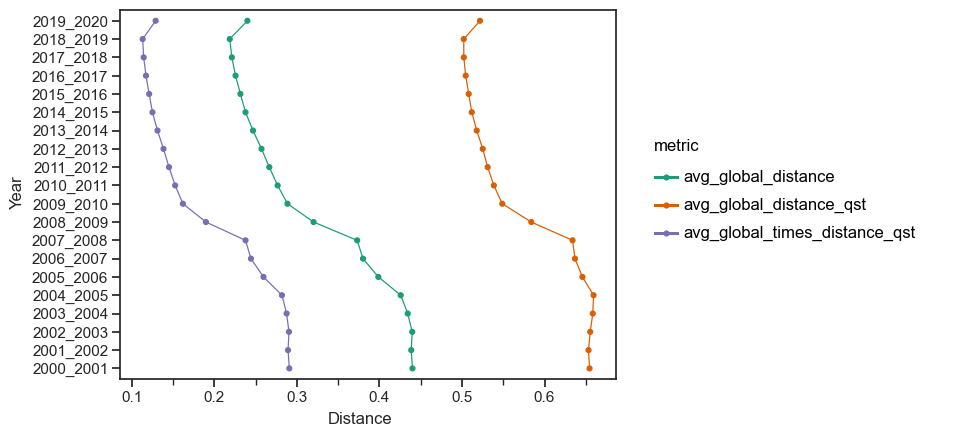

<ggplot: (8792352065249)>

In [10]:
(
    p9.ggplot(
        global_qst_comparison,
        p9.aes(x="year_pair", y="distance_value", color="metric", group="metric"),
    )
    + p9.geom_point()
    + p9.geom_line()
    + p9.coord_flip()
    + p9.theme_seaborn(style="white")
    + p9.scale_color_brewer("qual", palette=2)
    + p9.labs(y="Distance", x="Year")
)

In [11]:
middle_map = dict(
    global_qst_comparison
    >> ply.query("year_pair=='2010_2011'")
    >> ply.pull(["metric", "distance_value"])
)

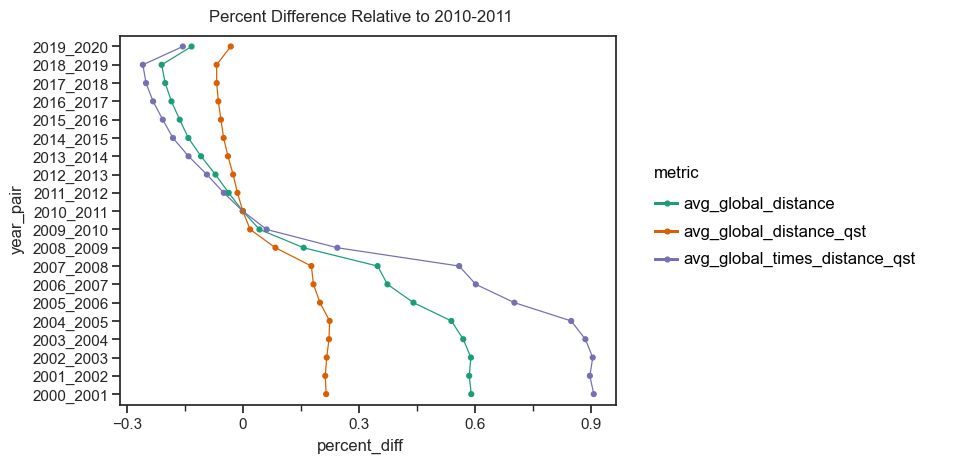

<ggplot: (-9223363244502742952)>

In [12]:
(
    global_qst_comparison
    >> ply.arrange("year_pair")
    >> ply.define(
        percent_diff=ply.expressions.case_when(
            {
                'metric=="avg_global_distance_qst"': f'distance_value/{middle_map["avg_global_distance_qst"]} - 1',
                'metric=="avg_global_distance"': f'distance_value/{middle_map["avg_global_distance"]} - 1',
                'metric=="avg_global_times_distance_qst"': f'distance_value/{middle_map["avg_global_times_distance_qst"]} - 1',
            }
        )
    )
    >> (
        p9.ggplot(
            p9.aes(x="year_pair", y="percent_diff", group="metric", color="metric")
        )
        + p9.geom_point()
        + p9.geom_line()
        + p9.coord_flip()
        + p9.theme_seaborn(style="white")
        + p9.labs(title="Percent Difference Relative to 2010-2011")
        + p9.scale_color_brewer("qual", palette=2)
    )
)

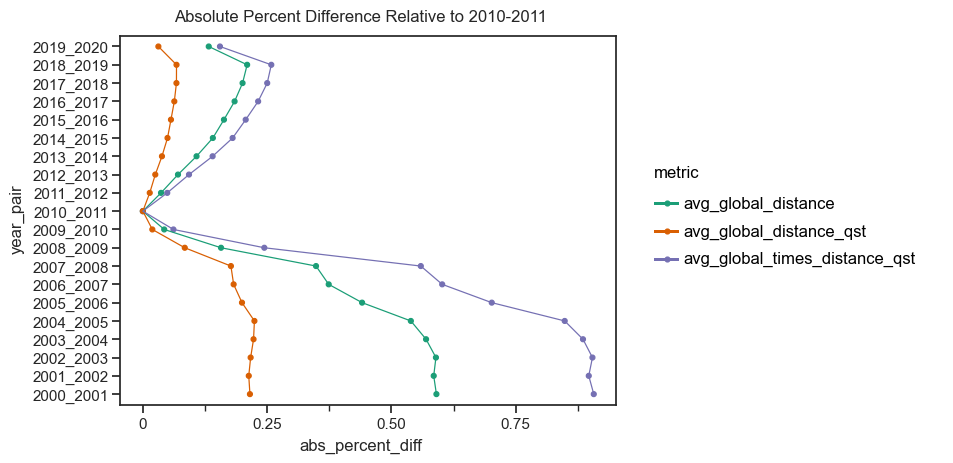

<ggplot: (-9223363244502776537)>

In [13]:
(
    global_qst_comparison
    >> ply.arrange("year_pair")
    >> ply.define(
        percent_diff=ply.expressions.case_when(
            {
                'metric=="avg_global_distance_qst"': f'distance_value/{middle_map["avg_global_distance_qst"]} - 1',
                'metric=="avg_global_distance"': f'distance_value/{middle_map["avg_global_distance"]} - 1',
                'metric=="avg_global_times_distance_qst"': f'distance_value/{middle_map["avg_global_times_distance_qst"]} - 1',
            }
        )
    )
    >> ply.define(abs_percent_diff="abs(percent_diff)")
    >> (
        p9.ggplot(
            p9.aes(x="year_pair", y="abs_percent_diff", group="metric", color="metric")
        )
        + p9.geom_point()
        + p9.geom_line()
        + p9.coord_flip()
        + p9.theme_seaborn(style="white")
        + p9.labs(title="Absolute Percent Difference Relative to 2010-2011")
        + p9.scale_color_brewer("qual", palette=2)
    )
)

# Does distance increase across the years when focusing on a single year?

## 2000

In [14]:
full_token_set_df = pd.concat(
    [
        year_distance_map[year]
        >> ply.query(f"tok in {token_filter_list}")
        >> ply.query("year_1 == 2000")
        for year in tqdm.tqdm(year_distance_map)
    ]
)
print(full_token_set_df.shape)
full_token_set_df.head()

100%|██████████| 20/20 [00:15<00:00,  1.30it/s]

(298840, 8)


,tok,original_global_distance,global_distance_qst,global_times_distance_qst,local_distance_qst,local_times_distance_qst,year_1,year_2
0,united,0.710870,0.737019,0.523925,0.924041,0.302456,2000,2017
1,combining,0.742832,0.867140,0.644140,0.997836,0.599636,2000,2017
2,purinergic,0.710384,0.652537,0.463552,0.930912,0.232051,2000,2017
3,decomposition,0.886063,0.776245,0.687802,0.966696,0.489906,2000,2017
4,60.0,0.783535,0.650033,0.509323,0.794930,0.376786,2000,2017


In [15]:
original_df = (
    full_token_set_df
    >> ply.arrange("tok")
    >> ply.group_by("year_2")
    >> ply.define(avg_global_distance="mean(original_global_distance)")
    >> ply.select("avg_global_distance", "year_1")
    >> ply.distinct()
    >> ply.ungroup()
    >> ply_tdy.unite("year_pair", "year_1", "year_2")
)
original_df >> ply.slice_rows(10)

,year_pair,avg_global_distance
248435,2000_2012,0.681394
124677,2000_2003,0.463308
218539,2000_2010,0.671795
203591,2000_2009,0.664901
158747,2000_2015,0.690646
143799,2000_2019,0.696785
84007,2000_2020,0.701157
42258,2000_2001,0.439978
278331,2000_2005,0.526808
113903,2000_2007,0.591500


In [16]:
qst_df = (
    full_token_set_df
    >> ply.arrange("tok")
    >> ply.group_by("year_2")
    >> ply.define(avg_global_distance_qst="mean(global_distance_qst)")
    >> ply.select("avg_global_distance_qst", "year_1")
    >> ply.distinct()
    >> ply.ungroup()
    >> ply_tdy.unite("year_pair", "year_1", "year_2")
)
qst_df >> ply.slice_rows(10)

,year_pair,avg_global_distance_qst
248435,2000_2012,0.756588
124677,2000_2003,0.672971
218539,2000_2010,0.752653
203591,2000_2009,0.751169
158747,2000_2015,0.762884
143799,2000_2019,0.769311
84007,2000_2020,0.766834
42258,2000_2001,0.654512
278331,2000_2005,0.711553
113903,2000_2007,0.738530


In [17]:
times_qst_df = (
    full_token_set_df
    >> ply.arrange("tok")
    >> ply.group_by("year_2")
    >> ply.define(avg_global_times_distance_qst="mean(global_times_distance_qst)")
    >> ply.select("avg_global_times_distance_qst", "year_1")
    >> ply.distinct()
    >> ply.ungroup()
    >> ply_tdy.unite("year_pair", "year_1", "year_2")
)
times_qst_df >> ply.slice_rows(10)

,year_pair,avg_global_times_distance_qst
248435,2000_2012,0.512956
124677,2000_2003,0.311860
218539,2000_2010,0.503064
203591,2000_2009,0.496772
158747,2000_2015,0.524159
143799,2000_2019,0.533070
84007,2000_2020,0.534676
42258,2000_2001,0.290793
278331,2000_2005,0.372223
113903,2000_2007,0.433524


In [18]:
global_qst_comparison = (
    original_df
    >> ply.inner_join(qst_df)
    >> ply.inner_join(times_qst_df)
    >> ply_tdy.gather(
        "metric",
        "distance_value",
        ply.select(
            "avg_global_distance_qst",
            "avg_global_times_distance_qst",
            "avg_global_distance",
        ),
    )
)
global_qst_comparison.year_pair = pd.Categorical(
    global_qst_comparison.year_pair.tolist()
)
global_qst_comparison.head(10)

,year_pair,metric,distance_value
0,2000_2012,avg_global_distance_qst,0.756588
1,2000_2003,avg_global_distance_qst,0.672971
2,2000_2010,avg_global_distance_qst,0.752653
3,2000_2009,avg_global_distance_qst,0.751169
4,2000_2015,avg_global_distance_qst,0.762884
5,2000_2019,avg_global_distance_qst,0.769311
6,2000_2020,avg_global_distance_qst,0.766834
7,2000_2001,avg_global_distance_qst,0.654512
8,2000_2005,avg_global_distance_qst,0.711553
9,2000_2007,avg_global_distance_qst,0.738530


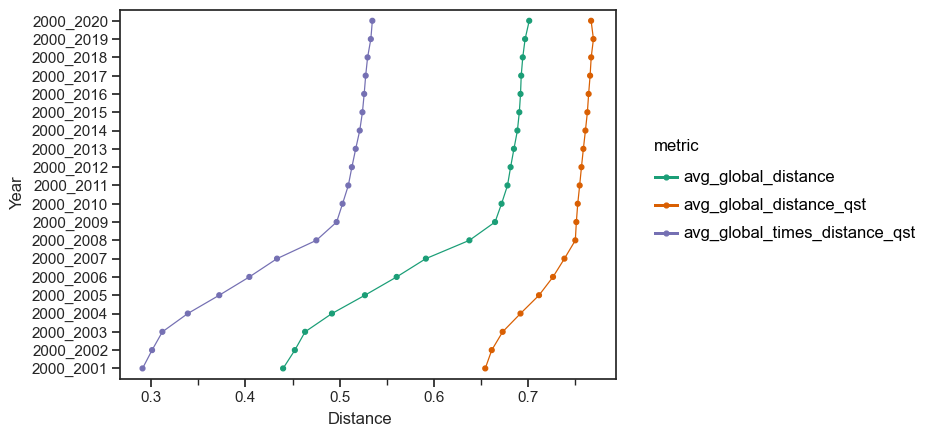

<ggplot: (-9223363268817430475)>

In [19]:
(
    p9.ggplot(
        global_qst_comparison,
        p9.aes(x="year_pair", y="distance_value", color="metric", group="metric"),
    )
    + p9.geom_point()
    + p9.geom_line()
    + p9.coord_flip()
    + p9.theme_seaborn(style="white")
    + p9.scale_color_brewer("qual", palette=2)
    + p9.labs(y="Distance", x="Year")
)

In [20]:
middle_map = dict(
    global_qst_comparison
    >> ply.query("year_pair=='2000_2010'")
    >> ply.pull(["metric", "distance_value"])
)

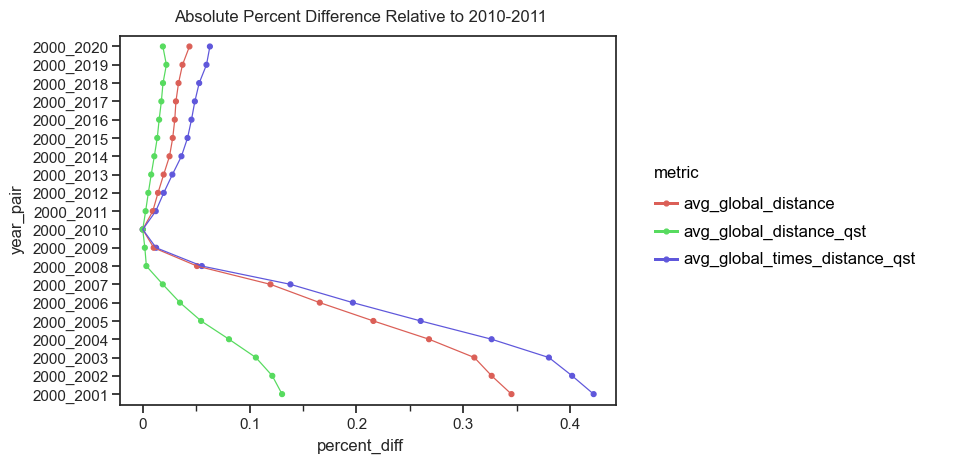

<ggplot: (-9223363268813294262)>

In [21]:
(
    global_qst_comparison
    >> ply.arrange("year_pair")
    >> ply.define(
        percent_diff=ply.expressions.case_when(
            {
                'metric=="avg_global_distance_qst"': f'abs(distance_value/{middle_map["avg_global_distance_qst"]} - 1)',
                'metric=="avg_global_distance"': f'abs(distance_value/{middle_map["avg_global_distance"]} - 1)',
                'metric=="avg_global_times_distance_qst"': f'abs(distance_value/{middle_map["avg_global_times_distance_qst"]} - 1)',
            }
        )
    )
    >> (
        p9.ggplot(
            p9.aes(x="year_pair", y="percent_diff", group="metric", color="metric")
        )
        + p9.geom_point()
        + p9.geom_line()
        + p9.coord_flip()
        + p9.theme_seaborn(style="white")
        + p9.labs(title="Absolute Percent Difference Relative to 2010-2011")
        + p9.scale_color_brewer("qual", palette=2)
    )
)

## 2001

In [22]:
full_token_set_df = pd.concat(
    [
        year_distance_map[year]
        >> ply.query(f"tok in {token_filter_list}")
        >> ply.query("year_1 == 2001")
        for year in tqdm.tqdm(year_distance_map)
    ]
)
print(full_token_set_df.shape)
full_token_set_df.head()

100%|██████████| 20/20 [00:13<00:00,  1.52it/s]

(283898, 8)


,tok,original_global_distance,global_distance_qst,global_times_distance_qst,local_distance_qst,local_times_distance_qst,year_1,year_2
0,united,0.087202,0.586560,0.051149,0.682248,0.000606,2001,2002
1,combining,0.309963,0.640601,0.198563,0.792100,0.014872,2001,2002
2,purinergic,1.073160,0.737593,0.791555,0.935588,1.052465,2001,2002
3,decomposition,0.449786,0.723298,0.325330,0.976385,0.094342,2001,2002
4,60.0,0.617936,0.604708,0.373671,0.784815,0.112556,2001,2002


In [23]:
original_df = (
    full_token_set_df
    >> ply.arrange("tok")
    >> ply.group_by("year_2")
    >> ply.define(avg_global_distance="mean(original_global_distance)")
    >> ply.select("avg_global_distance", "year_1")
    >> ply.distinct()
    >> ply.ungroup()
    >> ply_tdy.unite("year_pair", "year_1", "year_2")
)
original_df >> ply.slice_rows(10)

,year_pair,avg_global_distance
218450,2001_2017,0.670079
263276,2001_2012,0.657767
113856,2001_2007,0.561332
69030,2001_2010,0.648122
24204,2001_2003,0.445439
83972,2001_2005,0.496817
203508,2001_2008,0.610610
54088,2001_2016,0.669135
173624,2001_2014,0.665305
9262,2001_2002,0.438477


In [24]:
qst_df = (
    full_token_set_df
    >> ply.arrange("tok")
    >> ply.group_by("year_2")
    >> ply.define(avg_global_distance_qst="mean(global_distance_qst)")
    >> ply.select("avg_global_distance_qst", "year_1")
    >> ply.distinct()
    >> ply.ungroup()
    >> ply_tdy.unite("year_pair", "year_1", "year_2")
)
qst_df >> ply.slice_rows(10)

,year_pair,avg_global_distance_qst
218450,2001_2017,0.761555
263276,2001_2012,0.751855
113856,2001_2007,0.730101
69030,2001_2010,0.747694
24204,2001_2003,0.662663
83972,2001_2005,0.700260
203508,2001_2008,0.743816
54088,2001_2016,0.759944
173624,2001_2014,0.756291
9262,2001_2002,0.653246


In [25]:
times_qst_df = (
    full_token_set_df
    >> ply.arrange("tok")
    >> ply.group_by("year_2")
    >> ply.define(avg_global_times_distance_qst="mean(global_times_distance_qst)")
    >> ply.select("avg_global_times_distance_qst", "year_1")
    >> ply.distinct()
    >> ply.ungroup()
    >> ply_tdy.unite("year_pair", "year_1", "year_2")
)
times_qst_df >> ply.slice_rows(10)

,year_pair,avg_global_times_distance_qst
218450,2001_2017,0.507186
263276,2001_2012,0.491654
113856,2001_2007,0.406146
69030,2001_2010,0.481759
24204,2001_2003,0.296618
83972,2001_2005,0.345383
203508,2001_2008,0.450721
54088,2001_2016,0.505420
173624,2001_2014,0.500242
9262,2001_2002,0.289257


In [26]:
global_qst_comparison = (
    original_df
    >> ply.inner_join(qst_df)
    >> ply.inner_join(times_qst_df)
    >> ply_tdy.gather(
        "metric",
        "distance_value",
        ply.select(
            "avg_global_distance_qst",
            "avg_global_times_distance_qst",
            "avg_global_distance",
        ),
    )
)
global_qst_comparison.year_pair = pd.Categorical(
    global_qst_comparison.year_pair.tolist()
)
global_qst_comparison.head(10)

,year_pair,metric,distance_value
0,2001_2017,avg_global_distance_qst,0.761555
1,2001_2012,avg_global_distance_qst,0.751855
2,2001_2007,avg_global_distance_qst,0.730101
3,2001_2010,avg_global_distance_qst,0.747694
4,2001_2003,avg_global_distance_qst,0.662663
5,2001_2005,avg_global_distance_qst,0.700260
6,2001_2008,avg_global_distance_qst,0.743816
7,2001_2016,avg_global_distance_qst,0.759944
8,2001_2014,avg_global_distance_qst,0.756291
9,2001_2002,avg_global_distance_qst,0.653246


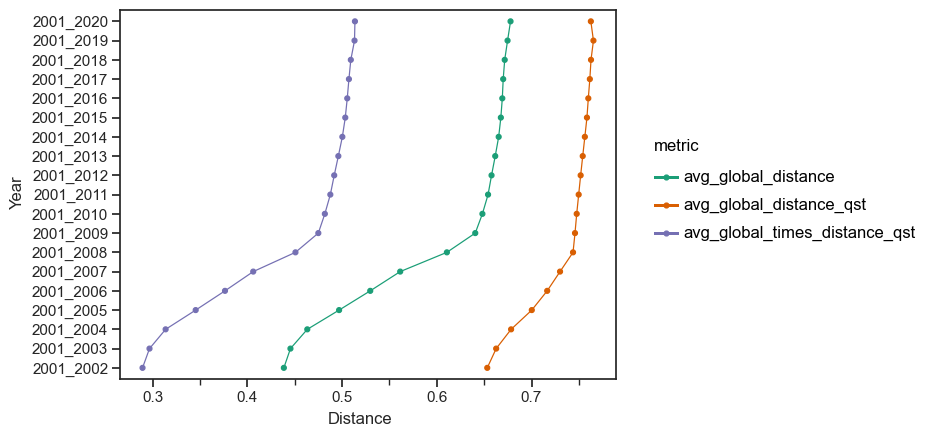

<ggplot: (-9223363268813288553)>

In [27]:
(
    p9.ggplot(
        global_qst_comparison,
        p9.aes(x="year_pair", y="distance_value", color="metric", group="metric"),
    )
    + p9.geom_point()
    + p9.geom_line()
    + p9.coord_flip()
    + p9.theme_seaborn(style="white")
    + p9.scale_color_brewer("qual", palette=2)
    + p9.labs(y="Distance", x="Year")
)

In [28]:
middle_map = dict(
    global_qst_comparison
    >> ply.query("year_pair=='2001_2010'")
    >> ply.pull(["metric", "distance_value"])
)

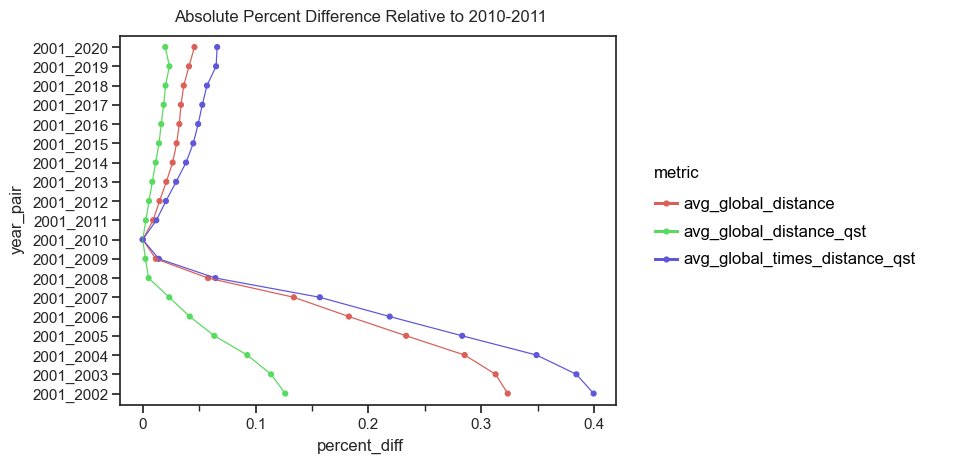

<ggplot: (-9223363268813394088)>

In [29]:
(
    global_qst_comparison
    >> ply.arrange("year_pair")
    >> ply.define(
        percent_diff=ply.expressions.case_when(
            {
                'metric=="avg_global_distance_qst"': f'abs(distance_value/{middle_map["avg_global_distance_qst"]} - 1)',
                'metric=="avg_global_distance"': f'abs(distance_value/{middle_map["avg_global_distance"]} - 1)',
                'metric=="avg_global_times_distance_qst"': f'abs(distance_value/{middle_map["avg_global_times_distance_qst"]} - 1)',
            }
        )
    )
    >> (
        p9.ggplot(
            p9.aes(x="year_pair", y="percent_diff", group="metric", color="metric")
        )
        + p9.geom_point()
        + p9.geom_line()
        + p9.coord_flip()
        + p9.theme_seaborn(style="white")
        + p9.labs(title="Absolute Percent Difference Relative to 2010-2011")
        + p9.scale_color_brewer("qual", palette=2)
    )
)

Take home Points:
1. The metric that appears to be most stable is the qst metric: $\hat{Distance} = \frac{Distance_{inter\_year(x,y)}}{Distance_{inter\_year(x,y)} + Distance_{intra\_year(x)} + Distance_{intra\_year(y)}}$. Reason for this claim is that the green line in the following graphics above doesn't appear to have drastic spikes. This suggests year instability is corrected by using this metric.
2. When comparing one year to the rest the distance does change over time which is exactly what we were expecting to observe.